# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

## By Malak Alshedokih

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import operator
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Load in the feature summary file
data_dic = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')


In [4]:
data_dic

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# demographics data
print(" Number of rows: " ,azdias.shape[0])
print(" Number of columns: " ,azdias.shape[1])
print("------------------------------------------")
azdias.head()

 Number of rows:  891221
 Number of columns:  85
------------------------------------------


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
azdias.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
ALTERSKATEGORIE_GROB,891221.0,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,886367.0,3.632838,1.595021,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,891221.0,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,891221.0,2.821039,1.464749,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,891221.0,3.401106,1.322134,1.0,3.0,3.0,5.0,5.0
FINANZ_ANLEGER,891221.0,3.033328,1.529603,1.0,2.0,3.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,891221.0,2.874167,1.486731,1.0,2.0,3.0,4.0,5.0
FINANZ_HAUSBAUER,891221.0,3.075121,1.353248,1.0,2.0,3.0,4.0,5.0


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().any()

AGER_TYP                 False
ALTERSKATEGORIE_GROB     False
ANREDE_KZ                False
CJT_GESAMTTYP             True
FINANZ_MINIMALIST        False
FINANZ_SPARER            False
FINANZ_VORSORGER         False
FINANZ_ANLEGER           False
FINANZ_UNAUFFAELLIGER    False
FINANZ_HAUSBAUER         False
FINANZTYP                False
GEBURTSJAHR              False
GFK_URLAUBERTYP           True
GREEN_AVANTGARDE         False
HEALTH_TYP               False
LP_LEBENSPHASE_FEIN       True
LP_LEBENSPHASE_GROB       True
LP_FAMILIE_FEIN           True
LP_FAMILIE_GROB           True
LP_STATUS_FEIN            True
LP_STATUS_GROB            True
NATIONALITAET_KZ         False
PRAEGENDE_JUGENDJAHRE    False
RETOURTYP_BK_S            True
SEMIO_SOZ                False
SEMIO_FAM                False
SEMIO_REL                False
SEMIO_MAT                False
SEMIO_VERT               False
SEMIO_LUST               False
                         ...  
OST_WEST_KZ               True
WOHNLAGE

In [10]:
# print the Number of missing data
print("Number of missing data",azdias.isnull().sum().sum())

Number of missing data 4896838


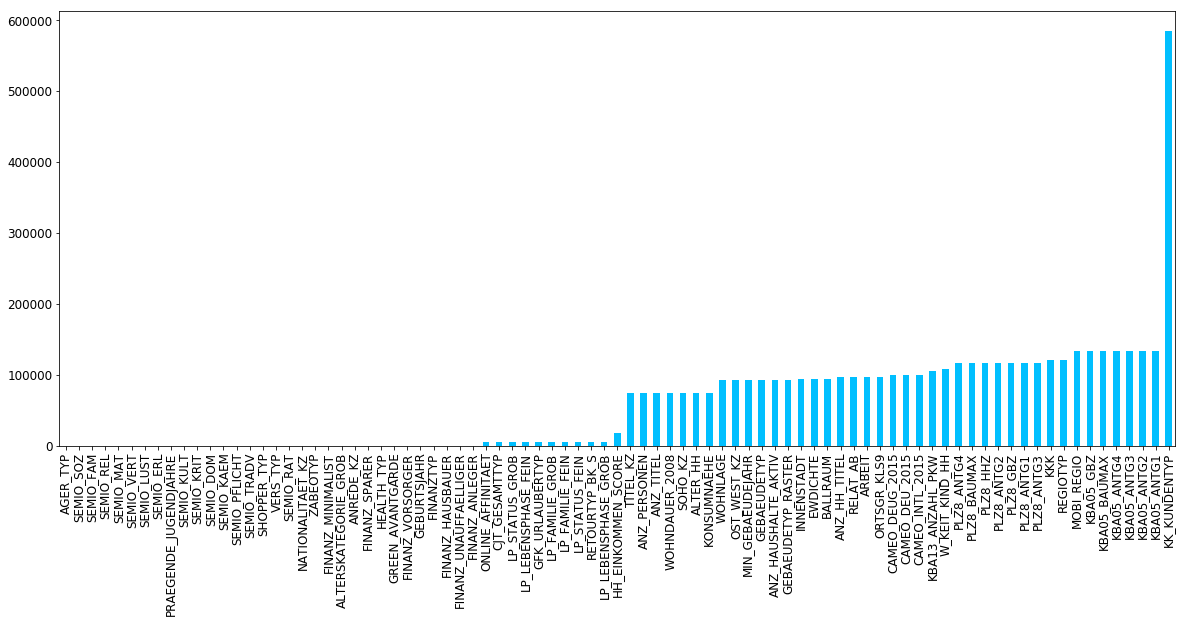

In [11]:
# Visualizing the data
azdias.isnull().sum().sort_values().plot.bar(figsize=(20,8),fontsize=12,color='deepskyblue');

In [12]:
azdias_new = azdias

In [13]:
azdias_new.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [14]:
# Identify missing or unknown data values and convert them to NaNs.
def convert_missing_to_nan(df):
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            df[column_name] = df[column_name].replace(hold,np.nan)
            
    return df

In [15]:
azdias_new = convert_missing_to_nan(azdias_new)

In [16]:
azdias_new.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [17]:
print("Number of missing data",azdias_new.isnull().sum().sum())

Number of missing data 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

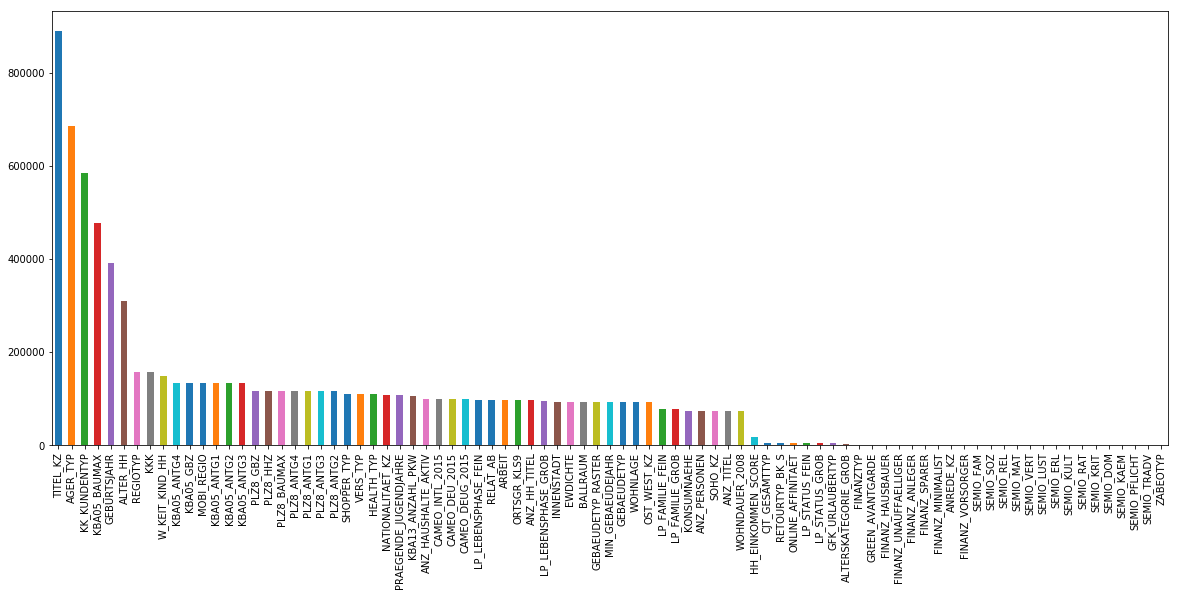

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_new.isnull().sum().sort_values(ascending=False).plot.bar(figsize=(20,8))

In [19]:
round(azdias_new.isnull().sum()/azdias.shape[0]*100,2).sort_values(ascending=False)

TITEL_KZ                 99.76
AGER_TYP                 76.96
KK_KUNDENTYP             65.60
KBA05_BAUMAX             53.47
GEBURTSJAHR              44.02
ALTER_HH                 34.81
REGIOTYP                 17.74
KKK                      17.74
W_KEIT_KIND_HH           16.61
KBA05_ANTG4              14.96
KBA05_GBZ                14.96
MOBI_REGIO               14.96
KBA05_ANTG1              14.96
KBA05_ANTG2              14.96
KBA05_ANTG3              14.96
PLZ8_GBZ                 13.07
PLZ8_HHZ                 13.07
PLZ8_BAUMAX              13.07
PLZ8_ANTG4               13.07
PLZ8_ANTG1               13.07
PLZ8_ANTG3               13.07
PLZ8_ANTG2               13.07
SHOPPER_TYP              12.48
VERS_TYP                 12.48
HEALTH_TYP               12.48
NATIONALITAET_KZ         12.15
PRAEGENDE_JUGENDJAHRE    12.14
KBA13_ANZAHL_PKW         11.87
ANZ_HAUSHALTE_AKTIV      11.18
CAMEO_INTL_2015          11.15
                         ...  
LP_STATUS_FEIN            0.54
LP_STATU

In [20]:
# Remove the outlier columns from the dataset. (Columns with more than 30% of data missing)

azdias_new.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],inplace=True,axis=1)


In [21]:
#Check
print(azdias_new.shape[0])
print(azdias_new.shape[1])

891221
79


#### Discussion 1.1.2: Assess Missing Data in Each Column

reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?
 
TITEL_KZ, AGER_TYP , KK_KUNDENTYP , KBA05_BAUMAX , GEBURTSJAHR , ALTER_HH are the outlire columns that they were dropped since they have a very big number of missing data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [22]:
# How much data is missing in each row of the dataset?
missing_data_row = azdias_new.isnull().sum(axis=1).value_counts().sort_index()
missing_data_row

0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64

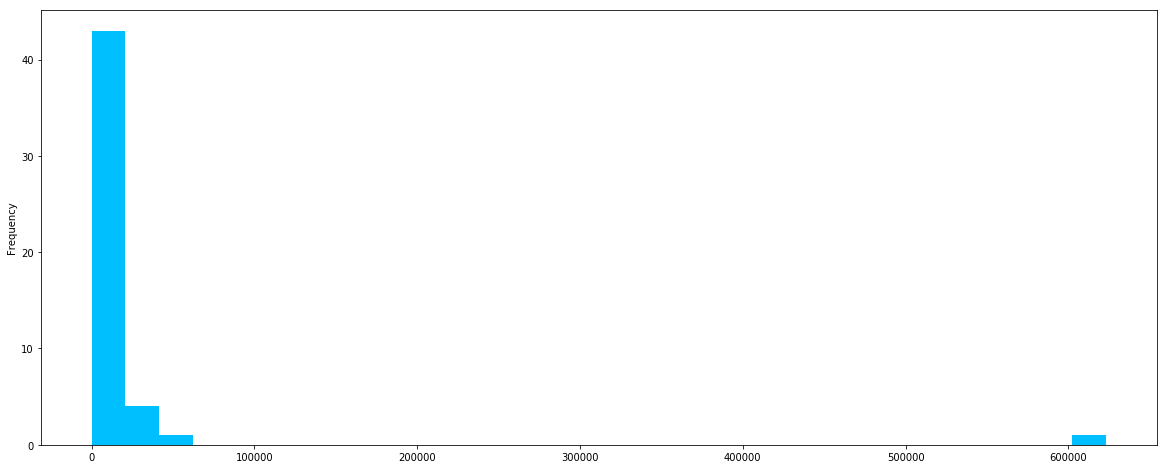

In [23]:
# Visualizing
missing_data_row.plot(kind='hist',bins=30,figsize=(20,8),color='deepskyblue');

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_row_low = azdias_new[azdias_new.isnull().sum(axis=1) < 20].reset_index(drop=True)
missing_row_high = azdias_new[azdias_new.isnull().sum(axis=1) >= 20].reset_index(drop=True)

In [25]:
print(" rows with low missing values ",missing_row_low.shape[0]," rows with high missing values " ,missing_row_high.shape[0])

 rows with low missing values  797077  rows with high missing values  94144


In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#function for comparison 

def count_plt (df_1, df_2, col):
    fig, ax =plt.subplots(1,2)
    sns.countplot(df_1[col], ax=ax[0])
    sns.countplot(df_2[col], ax=ax[1])
    plt.subplots_adjust(wspace= 0.4)
    fig.show()
    return

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


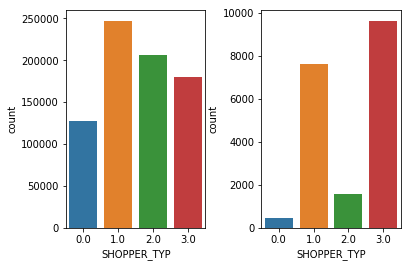

In [27]:
count_plt(missing_row_low, missing_row_high, 'SHOPPER_TYP')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


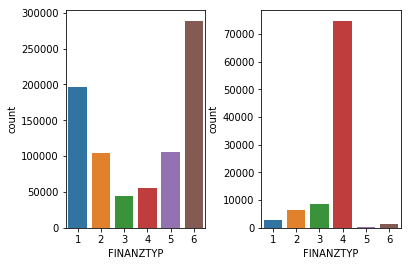

In [28]:
count_plt(missing_row_low, missing_row_high, 'FINANZTYP')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


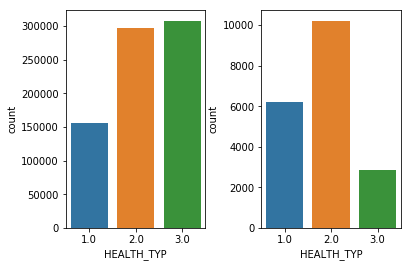

In [29]:
count_plt(missing_row_low, missing_row_high, 'HEALTH_TYP')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


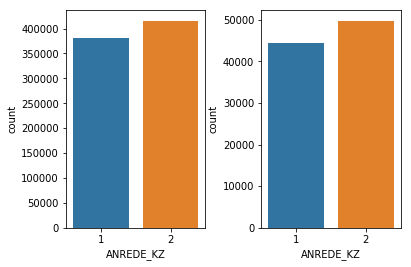

In [30]:
count_plt(missing_row_low, missing_row_high, 'ANREDE_KZ')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


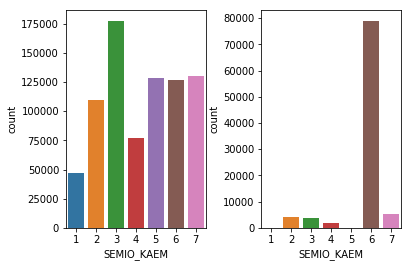

In [31]:
count_plt(missing_row_low, missing_row_high, 'SEMIO_KAEM')

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


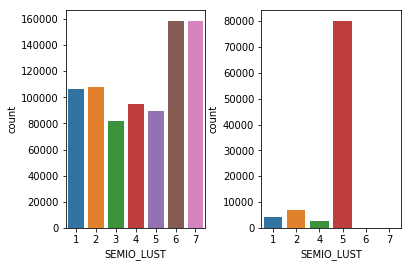

In [32]:
count_plt(missing_row_low, missing_row_high, 'SEMIO_LUST')

#### Discussion 1.1.3: Assess Missing Data in Each Row

Rows with high missing data were dropped for cleaner data and easier analysis later on.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
feat_info_new = feat_info

In [34]:
# How many features are there of each data type?
num_feature = feat_info_new.type.value_counts ()
num_feature

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [35]:
#categorical 
feat_info_new[feat_info_new['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [36]:
# Drooping columns from feat_info that were dropped previously in azdias dataset.
feat_info_new = feat_info_new[feat_info.attribute != 'TITEL_KZ']
feat_info_new = feat_info_new[feat_info.attribute != 'AGER_TYP']
feat_info_new = feat_info_new[feat_info.attribute != 'KK_KUNDENTYP']
feat_info_new = feat_info_new[feat_info.attribute != 'KBA05_BAUMAX']
feat_info_new = feat_info_new[feat_info.attribute != 'GEBURTSJAHR']
feat_info_new = feat_info_new[feat_info.attribute != 'ALTER_HH']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [37]:
feat_info_new.shape

(79, 4)

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [38]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Matching the 2 dataset to create a new one with only categorical features
categorical_feature = azdias_new[feat_info_new[feat_info_new['type'] =='categorical']['attribute']]

In [39]:
categorical_feature.head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,1,2.0,4,10.0,0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4,4C
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2,2A
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6,6B


In [40]:
binary = []
multi = []

for i in categorical_feature:
    length = len(categorical_feature[i].value_counts())
    if  length == 2:
        binary.append(i)
    else:
        multi.append(i)

In [41]:
print("The binary categoricals are : ", binary, )

print("The multi-level categoricals are : " ,multi )

The binary categoricals are :  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
The multi-level categoricals are :  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


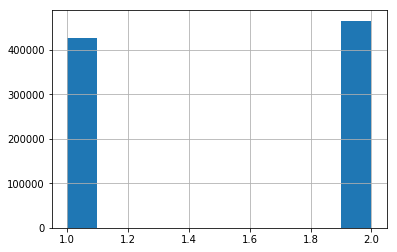

In [42]:
# look into the values of the binary categorical columns
azdias_new['ANREDE_KZ'].hist()

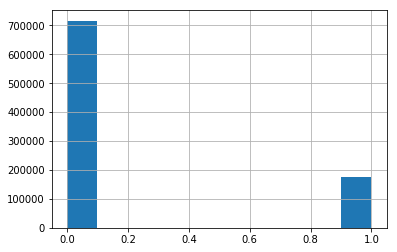

In [43]:
azdias_new['GREEN_AVANTGARDE'].hist()

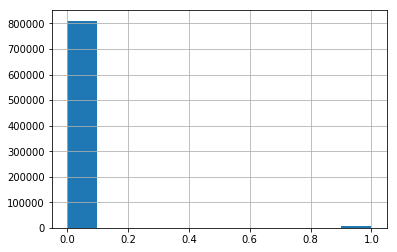

In [44]:
azdias_new['SOHO_KZ'].hist()

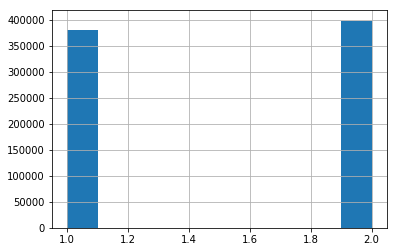

In [45]:
azdias_new['VERS_TYP'].hist()

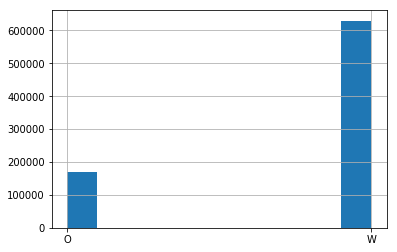

In [46]:
azdias_new['OST_WEST_KZ'].hist()

In [47]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Replacing OST_WEST_KZ values to be numerical binary   

azdias_new['OST_WEST_KZ'] = azdias_new['OST_WEST_KZ'].replace('O',0)

In [48]:
azdias_new['OST_WEST_KZ'] = azdias_new['OST_WEST_KZ'].replace('W',1)

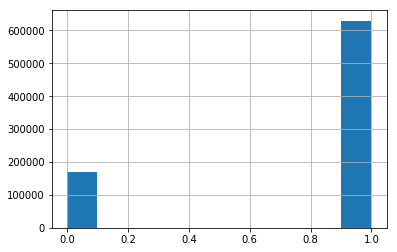

In [49]:
azdias_new['OST_WEST_KZ'].hist()

In [50]:
#Analyzing the multilevel variables

# 1    
azdias_new['CJT_GESAMTTYP'].value_counts().sort_index()

1.0     98869
2.0    148795
3.0    156449
4.0    210963
5.0    117376
6.0    153915
Name: CJT_GESAMTTYP, dtype: int64

In [51]:
# 2
azdias_new['FINANZTYP'].value_counts().sort_index()

1    199572
2    110867
3     53354
4    130625
5    106436
6    290367
Name: FINANZTYP, dtype: int64

In [52]:
# 3
azdias_new['GFK_URLAUBERTYP'].value_counts().sort_index()

1.0      53600
2.0      46702
3.0      56007
4.0      63770
5.0     120126
6.0      27138
7.0      42956
8.0      88042
9.0      60614
10.0    109127
11.0     79740
12.0    138545
Name: GFK_URLAUBERTYP, dtype: int64

In [53]:
# 3
azdias_new['GFK_URLAUBERTYP'].value_counts().sort_index()

1.0      53600
2.0      46702
3.0      56007
4.0      63770
5.0     120126
6.0      27138
7.0      42956
8.0      88042
9.0      60614
10.0    109127
11.0     79740
12.0    138545
Name: GFK_URLAUBERTYP, dtype: int64

In [54]:
# 4
azdias_new['LP_FAMILIE_FEIN'].value_counts().sort_index()

1.0     426379
2.0     104305
3.0       4958
4.0      12303
5.0      11920
6.0       9022
7.0      20730
8.0      23032
9.0      11148
10.0    137913
11.0     51719
Name: LP_FAMILIE_FEIN, dtype: int64

In [55]:
# 5
azdias_new['LP_FAMILIE_GROB'].value_counts().sort_index()

1.0    426379
2.0    104305
3.0     29181
4.0     52784
5.0    200780
Name: LP_FAMILIE_GROB, dtype: int64

In [56]:
# 6
azdias_new['LP_STATUS_FEIN'].value_counts().sort_index()

1.0     219275
2.0     118236
3.0      74105
4.0      78317
5.0      74493
6.0      30914
7.0      10059
8.0      19708
9.0     143238
10.0    118022
Name: LP_STATUS_FEIN, dtype: int64

In [57]:
# 7
azdias_new['LP_STATUS_GROB'].value_counts().sort_index()

1.0    337511
2.0    226915
3.0     40973
4.0    162946
5.0    118022
Name: LP_STATUS_GROB, dtype: int64

In [58]:
# 8
azdias_new['NATIONALITAET_KZ'].value_counts().sort_index()

1.0    684085
2.0     65418
3.0     33403
Name: NATIONALITAET_KZ, dtype: int64

In [59]:
# 9
azdias_new['SHOPPER_TYP'].value_counts().sort_index()

0.0    127582
1.0    254761
2.0    207463
3.0    190219
Name: SHOPPER_TYP, dtype: int64

In [60]:
# 10
azdias_new['ZABEOTYP'].value_counts().sort_index()

1    123622
2     33170
3    364905
4    210095
5     84956
6     74473
Name: ZABEOTYP, dtype: int64

In [61]:
# 11
azdias_new['GEBAEUDETYP'].value_counts().sort_index()

1.0    460465
2.0      4935
3.0    178668
4.0       900
5.0         1
6.0       628
8.0    152476
Name: GEBAEUDETYP, dtype: int64

In [62]:
# 12
azdias_new['CAMEO_DEUG_2015'].value_counts().sort_index()

1     36212
2     83231
3     86779
4    103912
5     55310
6    105874
7     77933
8    134441
9    108177
Name: CAMEO_DEUG_2015, dtype: int64

In [63]:
# 13
azdias_new['CAMEO_DEU_2015'].value_counts().sort_index()

1A    10850
1B     4071
1C     4317
1D    11909
1E     5065
2A    13249
2B    15486
2C    19422
2D    35074
3A    10543
3B     7160
3C    34769
3D    34307
4A    33155
4B     9047
4C    47819
4D     8570
4E     5321
5A    12214
5B    10354
5C     9935
5D    14943
5E     3581
5F     4283
6A     6810
6B    56672
6C    14820
6D     6073
6E    16107
6F     5392
7A    34399
7B    24503
7C     9065
7D     5333
7E     4633
8A    52438
8B    33434
8C    30993
8D    17576
9A    20542
9B    27676
9C    24987
9D    28593
9E     6379
Name: CAMEO_DEU_2015, dtype: int64

In [64]:
# Dropping the coulumns with multi-level categories
for i in categorical_feature:
    length = len(categorical_feature[i].value_counts())
    if  length == 2:
        print(i)
    else:
        azdias_new.drop(i, axis=1, inplace = True)

ANREDE_KZ
GREEN_AVANTGARDE
SOHO_KZ
VERS_TYP
OST_WEST_KZ


In [65]:
azdias_new.shape

(891221, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I had to replace the values in the column OST_WEST_KZ, to 0's and 1's.
I have dropped the multi-level categorical coulmns


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [66]:
# Mixed features
feat_info_new[feat_info_new['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [67]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_new['PRAEGENDE_JUGENDJAHRE'].head()

0     NaN
1    14.0
2    15.0
3     8.0
4     8.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [68]:
azdias_new['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [69]:
#Creating the column "AVANTGARDE" 
avantgarde = []

for x in azdias_new['PRAEGENDE_JUGENDJAHRE']:
    if x in [1,3,5,8,10,12,14]:
        avantgarde.append(0) #  0 for Mainstream
    elif x in [2,4,6,7,9,11,13,15]:
        avantgarde.append(1) #  1  Avantgarde
    else:
        avantgarde.append(np.nan)

In [70]:
# Add the column "AVANTGARDE" to azdias 
a = pd.Series(avantgarde)
azdias_new['AVANTGARDE'] = a.values
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AVANTGARDE
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0


In [71]:
# Add the column "generation" 
azdias_new['GENERATION'] = azdias_new['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:1,4:1,5:1,6:2,7:2,8:2,9:2,10:2,11:3,12:3,13:3,14:3,15:3})


In [72]:
# Check 
azdias_new['GENERATION'].value_counts().sort_index()


1.0    190823
2.0    295028
3.0    297206
Name: GENERATION, dtype: int64

In [73]:
# Drop the column PRAEGENDE_JUGENDJAHRE
azdias_new.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AVANTGARDE,GENERATION
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,3.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1.0,3.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0,2.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0.0,1.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0.0,2.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0.0,2.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,1.0,3.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,1.0,3.0


In [74]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_new['CAMEO_INTL_2015'].head()

0    NaN
1     51
2     24
3     12
4     43
Name: CAMEO_INTL_2015, dtype: object

In [75]:
azdias_new['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [76]:
azdias_new['CAMEO_INTL_2015']

0         NaN
1          51
2          24
3          12
4          43
5          54
6          22
7          14
8          13
9          15
10         51
11        NaN
12         43
13         33
14        NaN
15         41
16         41
17        NaN
18         24
19         34
20         24
21         55
22         51
23         43
24        NaN
25         33
26        NaN
27         51
28         13
29         12
         ... 
891191     44
891192     32
891193     43
891194     24
891195     55
891196     23
891197     24
891198     14
891199     51
891200     52
891201     41
891202     41
891203     25
891204     24
891205     34
891206     25
891207     41
891208     14
891209     51
891210     41
891211     51
891212     51
891213     34
891214     23
891215     31
891216     41
891217     51
891218     24
891219     51
891220     43
Name: CAMEO_INTL_2015, Length: 891221, dtype: object

In [77]:
# replacing NaN values with 0's
azdias_new['CAMEO_INTL_2015'].fillna(0,inplace=True)

In [78]:
azdias_new['CAMEO_INTL_2015'].isnull().sum()

0

In [79]:
azdias_new['WEALTH'] = azdias_new['CAMEO_INTL_2015'].str[0:1]

In [80]:
azdias_new['WEALTH'].fillna(0,inplace=True)

In [81]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AVANTGARDE,GENERATION,WEALTH
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,3.0,5
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1.0,3.0,2
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0,2.0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0,2.0,4


In [82]:
# Drop column CAMEO_INTL_2015
azdias_new.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

In [83]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AVANTGARDE,GENERATION,WEALTH
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,3.0,5
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1.0,3.0,2
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0,2.0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0,2.0,4


In [84]:
feat_info_new.query('type == "mixed"')

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [85]:
azdias_new.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace=True)

In [86]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AVANTGARDE,GENERATION,WEALTH
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,3.0,5
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,4.0,4.0,3.0,5.0,2.0,1.0,3.0,2
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0.0,2.0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0.0,2.0,4


#### Discussion 1.2.2: Engineer Mixed-Type Features

The 2 variables "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" were re-engineered into 3 new features. ("AVANTGARDE", "DECADE" AND "WEALTH")



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [87]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [88]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [89]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
    
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            df[column_name] = df[column_name].replace(hold,np.nan)
    ##
    # Remove the outlier columns from the dataset. 
    df.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'] ,inplace=True,axis=1)
    ##
    df['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)
     # Dropping the coulumns with multi-level categories
    categorical_feature = df[feat_info_new[feat_info_new['type'] =='categorical']['attribute']]
    for i in categorical_feature:
        length = len(categorical_feature[i].value_counts())
        if  length == 2:
            print(i)
        else:
            df.drop(i, axis=1, inplace = True)
    # create generation 
    df['GENERATION'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:1,4:1,5:1,6:2,7:2,8:2,9:2,10:2,11:3,12:3,13:3,14:3,15:3})
    # create movement
    avantgarde = []
    for x in df['PRAEGENDE_JUGENDJAHRE']:
        if x in [1,3,5,8,10,12,14]:
            avantgarde.append(0)
        elif x in [2,4,6,7,9,11,13,15]:
            avantgarde.append(1) 
        else:
            avantgarde.append(np.nan)
            
    a = pd.Series(avantgarde)
    df['AVANTGARDE'] = a.values
    # create wealth
    df['CAMEO_INTL_2015'].fillna(0,inplace=True)
    df['WEALTH'] = df['CAMEO_INTL_2015'].str[0:1]
    df['WEALTH'].fillna(0,inplace=True)
    # Drop the original column
    df.drop([  'PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_FEIN', 'WOHNLAGE', 'PLZ8_BAUMAX', 'CAMEO_INTL_2015'], axis=1, inplace=True)
   
    
    for s in df.columns:
        df[s] = df[s].interpolate(limit_direction='both')
        
    return df.head()
##    

    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    # remove selected columns and rows, ...

    
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [90]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_new.isnull().sum().sum()

4064050

In [91]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AVANTGARDE,GENERATION,WEALTH
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,3.0,5
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,4.0,4.0,3.0,5.0,2.0,1.0,3.0,2
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0.0,2.0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0.0,2.0,4


In [92]:
# Take a list of column headers
header_list = list(azdias_new.columns.values)
header_list

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 

In [93]:
# Apply feature scaling to the general population demographics data.
nan_data = azdias_new.columns[azdias_new.isna().any()].tolist()
imputer = Imputer(missing_values=np.nan, strategy="mean")
for feature in nan_data:
    azdias_new[feature] = imputer.fit_transform(azdias_new[[feature]])
azdias_new.isnull().sum().sum()

0

### Discussion 2.1: Apply Feature Scaling

Imuter was used first, then fit_transform the data 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

# Apply PCA to the data.



In [94]:
# Apply PCA to the data.
Scaler = StandardScaler()
azdias_new[azdias_new.columns] = Scaler.fit_transform(azdias_new[azdias_new.columns].as_matrix())
pca = PCA()
Scaler_pca = pca.fit_transform(azdias_new)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [95]:
azdias_new.shape 

(891221, 64)

In [96]:
# Investigate the variance accounted for by each principal component.
pca.explained_variance_ratio_

array([  1.61442872e-01,   1.38868314e-01,   9.28925283e-02,
         5.18855978e-02,   3.77285164e-02,   3.17215122e-02,
         2.96766927e-02,   2.72444833e-02,   2.37007715e-02,
         2.35032393e-02,   2.10697025e-02,   2.04583211e-02,
         1.97739641e-02,   1.86330212e-02,   1.70356113e-02,
         1.61943844e-02,   1.57991321e-02,   1.56148269e-02,
         1.40465425e-02,   1.29181056e-02,   1.23499337e-02,
         1.20661837e-02,   1.17438821e-02,   1.09600932e-02,
         1.03017780e-02,   8.90293697e-03,   7.59589128e-03,
         7.37566574e-03,   7.31006097e-03,   7.00860331e-03,
         6.70954652e-03,   6.53024811e-03,   6.45014655e-03,
         6.22464686e-03,   5.64699568e-03,   5.08259754e-03,
         4.96024855e-03,   4.77885197e-03,   4.54270028e-03,
         4.28240987e-03,   4.15608449e-03,   4.01900993e-03,
         3.87583916e-03,   3.70210301e-03,   3.51537906e-03,
         3.36991443e-03,   3.17732489e-03,   3.16170523e-03,
         2.80867533e-03,

In [97]:
pca.explained_variance_ratio_.cumsum()

array([ 0.16144287,  0.30031119,  0.39320371,  0.44508931,  0.48281783,
        0.51453934,  0.54421603,  0.57146052,  0.59516129,  0.61866453,
        0.63973423,  0.66019255,  0.67996652,  0.69859954,  0.71563515,
        0.73182953,  0.74762866,  0.76324349,  0.77729003,  0.79020814,
        0.80255807,  0.81462426,  0.82636814,  0.83732823,  0.84763001,
        0.85653295,  0.86412884,  0.8715045 ,  0.87881456,  0.88582317,
        0.89253271,  0.89906296,  0.90551311,  0.91173776,  0.91738475,
        0.92246735,  0.9274276 ,  0.93220645,  0.93674915,  0.94103156,
        0.94518764,  0.94920665,  0.95308249,  0.9567846 ,  0.96029998,
        0.96366989,  0.96684721,  0.97000892,  0.9728176 ,  0.97552854,
        0.97817837,  0.98074357,  0.98316567,  0.98547756,  0.98765724,
        0.98965938,  0.99160862,  0.99352239,  0.99519007,  0.99679372,
        0.99806215,  0.99930098,  0.99992151,  1.        ])

In [98]:
num_components = len(pca.explained_variance_ratio_)
    
num_components

64

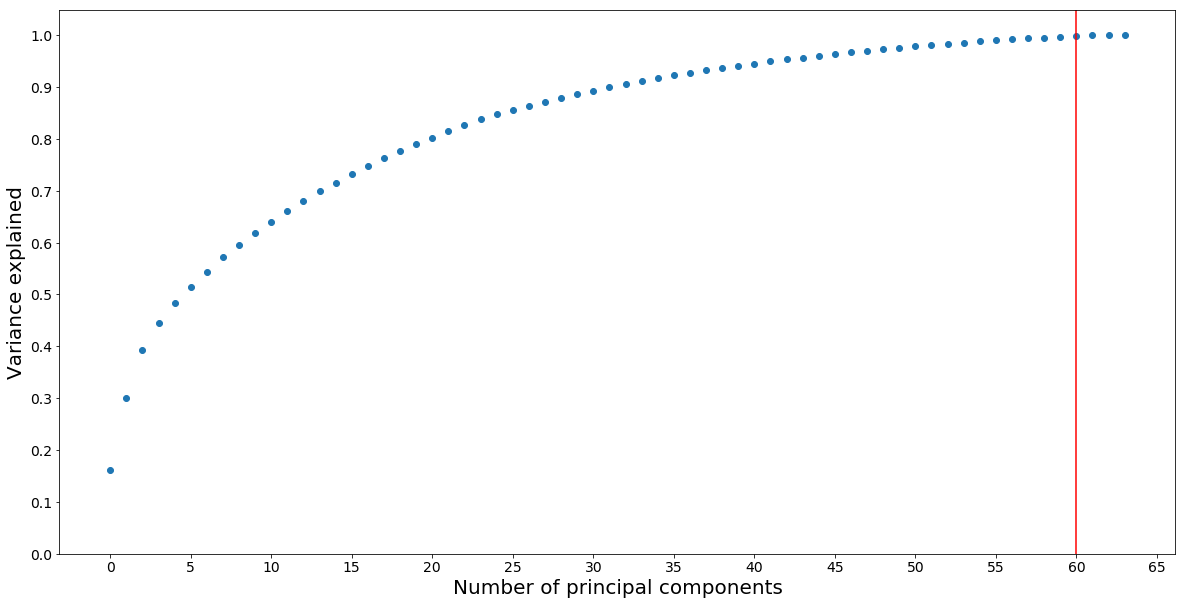

In [99]:
x = np.arange(num_components)
y = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(20,10))
plt.scatter(x = x, y = y)
plt.xlabel("Number of principal components", size = 20)
plt.ylabel("Variance explained", size = 20)
plt.xticks(np.arange(0, max(x)+5, 5), fontsize=14)
plt.yticks(np.arange(0,1.1,0.1), fontsize=14)
plt.axvline(60, color = 'red');

Re-do the PCA with 60

In [100]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA()
final_pca = pca.fit_transform(azdias_new)

### Discussion 2.2: Perform Dimensionality Reduction

The above plot shows that 60 is the optimal number of components

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [101]:
# components of the latest PCA
pca.components_

array([[-0.13479365,  0.00814841, -0.22725705, ..., -0.09965648,
         0.10629268,  0.15570852],
       [ 0.24555107,  0.04294052,  0.06265022, ..., -0.027605  ,
        -0.24645069,  0.10711297],
       [ 0.02779544, -0.36283476,  0.12961702, ...,  0.03631102,
        -0.03918252,  0.07089677],
       ..., 
       [ 0.06711645, -0.03563638, -0.34521712, ..., -0.0089196 ,
         0.00942793, -0.00418051],
       [-0.01789723, -0.002597  , -0.02106449, ..., -0.02043035,
         0.65357273,  0.00299191],
       [-0.03266454,  0.01723463, -0.01125751, ...,  0.7001011 ,
        -0.00647928,  0.01807907]])

In [102]:
#value of variance explained
pca.explained_variance_ratio_

array([  1.61442872e-01,   1.38868314e-01,   9.28925283e-02,
         5.18855978e-02,   3.77285164e-02,   3.17215122e-02,
         2.96766927e-02,   2.72444833e-02,   2.37007715e-02,
         2.35032393e-02,   2.10697025e-02,   2.04583211e-02,
         1.97739641e-02,   1.86330212e-02,   1.70356113e-02,
         1.61943844e-02,   1.57991321e-02,   1.56148269e-02,
         1.40465425e-02,   1.29181056e-02,   1.23499337e-02,
         1.20661837e-02,   1.17438821e-02,   1.09600932e-02,
         1.03017780e-02,   8.90293697e-03,   7.59589128e-03,
         7.37566574e-03,   7.31006097e-03,   7.00860331e-03,
         6.70954652e-03,   6.53024811e-03,   6.45014655e-03,
         6.22464686e-03,   5.64699568e-03,   5.08259754e-03,
         4.96024855e-03,   4.77885197e-03,   4.54270028e-03,
         4.28240987e-03,   4.15608449e-03,   4.01900993e-03,
         3.87583916e-03,   3.70210301e-03,   3.51537906e-03,
         3.36991443e-03,   3.17732489e-03,   3.16170523e-03,
         2.80867533e-03,

In [103]:
#dataframe of Explained Variance
dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
ratio = ratio.round(4)
ratio.index = dimensions
ratio[:5]

,EXPLAINED_VARIANCE
PC 1,0.1614
PC 2,0.1389
PC 3,0.0929
PC 4,0.0519
PC 5,0.0377


In [104]:
#dataframe with the weights for each pca
weights = pd.DataFrame(pca.components_)
weights = weights.round(2)
weights.index = dimensions
weights[:5]

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
PC 1,-0.13,0.01,-0.23,0.16,-0.13,0.08,0.09,0.15,-0.10,0.04,...,0.23,0.22,0.04,-0.17,0.14,0.20,0.14,-0.10,0.11,0.16
PC 2,0.25,0.04,0.06,-0.24,0.23,-0.22,-0.23,0.13,-0.02,-0.06,...,0.11,0.10,0.02,-0.08,0.08,0.10,0.07,-0.03,-0.25,0.11
PC 3,0.03,-0.36,0.13,-0.07,0.05,-0.16,-0.09,-0.06,0.05,-0.01,...,0.03,0.03,-0.00,-0.03,0.02,0.02,0.02,0.04,-0.04,0.07
PC 4,-0.01,0.01,0.09,-0.02,0.00,-0.12,0.07,-0.12,0.40,0.00,...,0.10,0.08,0.14,0.04,0.06,0.25,0.10,0.41,0.09,-0.11
PC 5,0.01,0.01,0.08,-0.01,-0.06,0.02,-0.06,-0.09,0.07,0.02,...,-0.03,0.01,-0.49,-0.40,0.22,0.09,0.15,0.06,0.07,0.02


In [105]:
# Combine them
result = pd.concat([ratio, weights], axis = 1, sort=False, join_axes=[ratio.index])
result[:5]

,EXPLAINED_VARIANCE,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
PC 1,0.1614,-0.13,0.01,-0.23,0.16,-0.13,0.08,0.09,0.15,-0.10,...,0.23,0.22,0.04,-0.17,0.14,0.20,0.14,-0.10,0.11,0.16
PC 2,0.1389,0.25,0.04,0.06,-0.24,0.23,-0.22,-0.23,0.13,-0.02,...,0.11,0.10,0.02,-0.08,0.08,0.10,0.07,-0.03,-0.25,0.11
PC 3,0.0929,0.03,-0.36,0.13,-0.07,0.05,-0.16,-0.09,-0.06,0.05,...,0.03,0.03,-0.00,-0.03,0.02,0.02,0.02,0.04,-0.04,0.07
PC 4,0.0519,-0.01,0.01,0.09,-0.02,0.00,-0.12,0.07,-0.12,0.40,...,0.10,0.08,0.14,0.04,0.06,0.25,0.10,0.41,0.09,-0.11
PC 5,0.0377,0.01,0.01,0.08,-0.01,-0.06,0.02,-0.06,-0.09,0.07,...,-0.03,0.01,-0.49,-0.40,0.22,0.09,0.15,0.06,0.07,0.02


In [106]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i):
    weight_map = {}
    for s, feature in enumerate(azdias_new.columns):
        weight_map[feature] = pca.components_[i][s]
    
    sorted_weights = sorted(weight_map.items(), reverse=True,key=operator.itemgetter(1))
    
    return sorted_weights

In [107]:
weights = pca_weights(pca,1)
pprint.pprint(weights)

[('ALTERSKATEGORIE_GROB', 0.24555106748033681),
 ('FINANZ_VORSORGER', 0.23387776158362397),
 ('SEMIO_ERL', 0.20045542549602433),
 ('SEMIO_LUST', 0.16886648536159929),
 ('RETOURTYP_BK_S', 0.16792907461586434),
 ('W_KEIT_KIND_HH', 0.13039190461455899),
 ('FINANZ_HAUSBAUER', 0.12621585522894224),
 ('PLZ8_ANTG3', 0.1093806452016225),
 ('WEALTH', 0.10711296611189594),
 ('PLZ8_ANTG4', 0.10480892243448858),
 ('EWDICHTE', 0.1036150362604627),
 ('ORTSGR_KLS9', 0.10206807582459304),
 ('HH_EINKOMMEN_SCORE', 0.090791958864424385),
 ('KBA05_ANTG4', 0.080159172334276732),
 ('ARBEIT', 0.077185637028930845),
 ('PLZ8_ANTG2', 0.075561105028476433),
 ('RELAT_AB', 0.074565087241491593),
 ('ANZ_HAUSHALTE_AKTIV', 0.073961503903920991),
 ('FINANZ_MINIMALIST', 0.062650221916029758),
 ('WOHNDAUER_2008', 0.05783589956290841),
 ('KBA05_ANTG3', 0.05435248615664031),
 ('SEMIO_KAEM', 0.05322901950937204),
 ('SEMIO_KRIT', 0.051176044303177869),
 ('ANREDE_KZ', 0.042940518760224422),
 ('VERS_TYP', 0.034060732662641438

In [108]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights = pca_weights(pca,2)
pprint.pprint(weights)

[('SEMIO_VERT', 0.35403555527304181),
 ('SEMIO_SOZ', 0.29347121103438939),
 ('SEMIO_KULT', 0.29160119052117994),
 ('SEMIO_FAM', 0.24351322930203931),
 ('FINANZ_MINIMALIST', 0.12961701855595151),
 ('SEMIO_MAT', 0.075654099641661865),
 ('RETOURTYP_BK_S', 0.071124795302030572),
 ('WEALTH', 0.07089676586759544),
 ('SEMIO_REL', 0.069846662954848288),
 ('W_KEIT_KIND_HH', 0.060375119635152248),
 ('GREEN_AVANTGARDE', 0.053684429042337216),
 ('FINANZ_VORSORGER', 0.053449812406792807),
 ('AVANTGARDE', 0.0363110188691705),
 ('ALTERSKATEGORIE_GROB', 0.027795437293786709),
 ('PLZ8_ANTG4', 0.027547081462558864),
 ('HH_EINKOMMEN_SCORE', 0.026851284275890945),
 ('PLZ8_ANTG3', 0.026681209993275796),
 ('ORTSGR_KLS9', 0.024804286376140412),
 ('EWDICHTE', 0.02340509235537969),
 ('ARBEIT', 0.021768384615577036),
 ('RELAT_AB', 0.018565432451467318),
 ('PLZ8_ANTG2', 0.017353985498584995),
 ('WOHNDAUER_2008', 0.01600937004657536),
 ('KBA05_ANTG4', 0.014022569701868442),
 ('ANZ_HAUSHALTE_AKTIV', 0.013833651351

In [109]:
# Map weights for the 3rd PC to corresponding feature names
# and then print the linked values, sorted by weight.
weights = pca_weights(pca,3)
pprint.pprint(weights)

[('AVANTGARDE', 0.41301573858940704),
 ('GREEN_AVANTGARDE', 0.40281569994021738),
 ('EWDICHTE', 0.25999821814866519),
 ('ORTSGR_KLS9', 0.2477532513931347),
 ('PLZ8_HHZ', 0.13893508075554714),
 ('ONLINE_AFFINITAET', 0.11753939820977875),
 ('OST_WEST_KZ', 0.10644854790462238),
 ('PLZ8_ANTG2', 0.10467487826409784),
 ('KBA05_ANTG1', 0.10232306468307172),
 ('ANZ_PERSONEN', 0.098559087048183155),
 ('PLZ8_ANTG3', 0.098439787170222004),
 ('RELAT_AB', 0.09687373432793156),
 ('SEMIO_DOM', 0.094310414338551668),
 ('GENERATION', 0.091746037227331198),
 ('FINANZ_MINIMALIST', 0.091255977282897277),
 ('PLZ8_ANTG4', 0.080222959480871714),
 ('MOBI_REGIO', 0.069289242320331068),
 ('FINANZ_UNAUFFAELLIGER', 0.068731411507541473),
 ('SEMIO_KAEM', 0.062407781587478742),
 ('KBA05_GBZ', 0.060550777970086102),
 ('PRAEGENDE_JUGENDJAHRE', 0.058470171905228865),
 ('ARBEIT', 0.055273935900957222),
 ('ANZ_TITEL', 0.050703261748213678),
 ('KBA13_ANZAHL_PKW', 0.050509270964513284),
 ('ANZ_HH_TITEL', 0.037436582153929

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


The first component associated with:

Postive: 
- ALTERSKATEGORIE_GROB 0.245
- FINANZ_VORSORGER , 0.233

Negative: 
- GENERATION  -0.2464 
- PRAEGENDE_JUGENDJAHRE -0.2561

The second component:

Postive: 
- SEMIO_VERT  0.354
- SEMIO_SOZ 0.2934

Negative: 
- ANREDE_KZ  -0.3628
- SEMIO_KAEM -0.3631

The third component:

Positive:

- AVANTGARDE, 0.4130

- GREEN_AVANTGARDE, 0.4028
Negative:

- HH_EINKOMMEN_SCORE, -0.2472

- KKK, -0.2741


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [110]:
# Over a number of different cluster counts...
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=i)

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(data))
    return score
scores = []
centers = list(range(1, 20, 2))

for center in centers:
    scores.append(get_kmeans_score(Scaler_pca, center))
print(scores)
    

[57038143.999999978, 46322373.941355556, 42063720.738709271, 39500217.706044137, 37814474.701270089, 36087454.068832904, 35016922.005897224, 33956422.139780156, 33565689.863355584, 33009454.921300918]


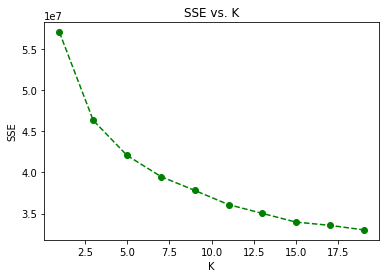

In [111]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='g');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [112]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=11)
model_general = kmeans.fit(Scaler_pca)
predict_general = model_general.predict(Scaler_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

From the graph above, the elbow is at 11. so it was used as n_clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [113]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')


In [114]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

clean_data(customers)

ANREDE_KZ
GREEN_AVANTGARDE
SOHO_KZ
VERS_TYP
OST_WEST_KZ


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION,AVANTGARDE,WEALTH
0,4.0,1,5,1,5,1,2,2,1,1.0,...,1.0,0.0,5.0,5.0,1.0,2.0,1.0,1.0,1.0,1
1,4.0,1,5,1,5,1,3,2,0,1.0,...,2.0,0.5,4.0,3.5,2.0,3.5,2.0,1.0,1.0,0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,3.0,1.0,3.0,2.0,3.0,5.0,3.0,1.0,1.0,3
3,4.0,1,5,1,5,2,1,2,0,2.0,...,1.0,0.0,3.0,4.0,1.0,3.0,1.0,1.0,0.0,2
4,3.0,1,3,1,4,4,5,2,0,3.0,...,2.0,1.0,3.0,3.0,3.0,5.0,1.0,2.0,0.0,4


In [115]:
customers.shape, azdias_new.shape

((191652, 64), (891221, 64))

In [116]:
# Apply feature scaling to the general population demographics data.
nan_data = customers.columns[customers.isna().any()].tolist()
imputer = Imputer(missing_values=np.nan, strategy="mean")
for feature in nan_data:
    customers[feature] = imputer.fit_transform(customers[[feature]])
customers.isnull().sum().sum()

0

In [117]:
Scaler.transform(customers)

array([[ 1.23253304, -1.045218  ,  1.45752682, ...,  1.98696292,
        -1.55819224, -1.10350807],
       [ 1.23253304, -1.045218  ,  1.45752682, ...,  1.98696292,
        -1.55819224, -1.68477787],
       [ 1.23253304,  0.95673821,  1.45752682, ...,  1.98696292,
        -1.55819224,  0.05903154],
       ..., 
       [ 1.23253304, -1.045218  ,  1.45752682, ...,  1.98696292,
        -1.55819224, -0.52223826],
       [ 0.24078076,  0.95673821, -0.81338684, ...,  4.54672487,
        -2.93001423, -0.52223826],
       [-0.75097152, -1.045218  ,  1.45752682, ...,  1.98696292,
        -2.93001423,  0.05903154]])

In [118]:
customers_pca = pca.transform(customers)
customers_pca.shape

(191652, 64)

In [119]:
#clustering preprocess
customers[customers.columns] = Scaler.transform(customers[customers.columns].as_matrix())
customers_pca = pca.transform(customers)
customers_pred = model_general.predict(customers_pca)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

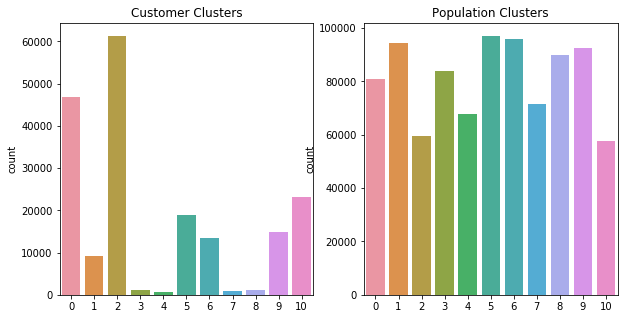

In [120]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust()
sns.countplot(customers_pred, ax=axs[0]);
axs[0].set_title('Customer Clusters');
sns.countplot(predict_general, ax=axs[1]);
axs[1].set_title('Population Clusters');

In [121]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_4 = Scaler.inverse_transform(pca.inverse_transform(model_general.cluster_centers_[4]))
overrepresented = pd.Series(centroid_4, index = customers.columns)
overrepresented

ALTERSKATEGORIE_GROB        1.876885
ANREDE_KZ                   1.000030
FINANZ_MINIMALIST           1.924712
FINANZ_SPARER               4.373844
FINANZ_VORSORGER            2.038721
FINANZ_ANLEGER              3.462791
FINANZ_UNAUFFAELLIGER       3.704896
FINANZ_HAUSBAUER            3.584751
GREEN_AVANTGARDE            0.122491
HEALTH_TYP                  2.389462
LP_LEBENSPHASE_GROB        12.941512
RETOURTYP_BK_S              2.840512
SEMIO_SOZ                   6.501084
SEMIO_FAM                   6.622601
SEMIO_REL                   6.041464
SEMIO_MAT                   5.138879
SEMIO_VERT                  6.062543
SEMIO_LUST                  3.028469
SEMIO_ERL                   2.408980
SEMIO_KULT                  6.557742
SEMIO_RAT                   3.897777
SEMIO_KRIT                  2.913546
SEMIO_DOM                   2.749502
SEMIO_KAEM                  2.507221
SEMIO_PFLICHT               5.774549
SEMIO_TRADV                 4.580945
SOHO_KZ                     0.008010
V

In [122]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_2 = Scaler.inverse_transform(pca.inverse_transform(model_general.cluster_centers_[2]))
underrepresented = pd.Series(centroid_2, index = customers.columns)
underrepresented

ALTERSKATEGORIE_GROB        3.421457
ANREDE_KZ                   1.000471
FINANZ_MINIMALIST           4.705472
FINANZ_SPARER               1.684492
FINANZ_VORSORGER            4.217719
FINANZ_ANLEGER              1.545280
FINANZ_UNAUFFAELLIGER       2.145499
FINANZ_HAUSBAUER            1.910061
GREEN_AVANTGARDE            0.995259
HEALTH_TYP                  2.070610
LP_LEBENSPHASE_GROB         7.933665
RETOURTYP_BK_S              3.975449
SEMIO_SOZ                   4.881836
SEMIO_FAM                   4.589560
SEMIO_REL                   3.798537
SEMIO_MAT                   3.841489
SEMIO_VERT                  6.185324
SEMIO_LUST                  5.286358
SEMIO_ERL                   4.007044
SEMIO_KULT                  5.030999
SEMIO_RAT                   2.814121
SEMIO_KRIT                  3.176902
SEMIO_DOM                   3.498176
SEMIO_KAEM                  2.527915
SEMIO_PFLICHT               3.108296
SEMIO_TRADV                 3.237926
SOHO_KZ                     0.008624
V

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)


Cluster 4 is over-represented in the customers data compared, as compared to the general population.
1- Generation is 0.0944
2- Wealth is 4.280496

Cluster 0 is the under represented cluster.
1- Generation is 0.3142
2- Wealth is 2.361818

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

### References:
https://github.com/paulstancliffe/Udacity-Arvato-Unsupervised/blob/master/Identify_Customer_Segments.ipynb
https://github.com/sanjeevai/customer_segments_arvato/blob/master/Identify_Customer_Segments.ipynb
https://github.com/ManarAlharbi/DSND-Term1-Identify_Customer_Segments/blob/master/Identify_Customer_Segments.ipynb